[1995年から2015年までの言語処理学会大会論文リスト anlp-jp-history.json](http://dx.doi.org/10.6084/m9.figshare.1511379) を集計して

* 投稿数の多い著者のリスト
* 年ごとの投稿数
* 年ごとの共著数
* 年ごとの継続投稿者数

を集計・表示するスクリプトです。

単純な正規表現によるルールで著者リストを分割しているため、分割誤りが残っている可能性があります。
また、同一人物の名前の表記ゆれは別扱いになってしまっています。

In [1]:
import six.moves.urllib.request as urlreq
from six.moves import xrange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import codecs
import re


def split_authors(a):
    # remove non-names first, normalize whitespaces
    a = re.sub(u'[\(（][株][\)）]', '', a)
    a = re.sub(u'(([一-龠]) +([一-龠]))', lambda x: x.group(2)+x.group(3), a)
    a = re.sub(u'((\w)　(\w))', lambda x: x.group(2)+' '+x.group(3), a)
    
    # remove markups
    a = re.sub(u'[○〇◯◎]', '', a)
    a = re.sub(u' *[\(（].*?[\)）]', '', a)

    ret = []
    for x in re.finditer(u'([A-Z][\'\.\-\w]+,[\-\w ]+|[ァ-ヾ\.\-A-Za-z]+・[ァ-ヾ\.\-A-Za-z・]+|[^ ,，・a-zA-Z]+|[A-Z][\'\.\-\w]+ [\'\.\-\w ]+)', a, re.UNICODE):
        ret.append(x.group(1))
    return [x.strip() for x in ret]


assert split_authors(u'エリック・ニコルズ，渡邉陽太郎 (東北大)') == [u'エリック・ニコルズ', u'渡邉陽太郎']
assert split_authors(u'荒木哲郎 (福井大)，池原悟 (NTT)') == [u'荒木哲郎', u'池原悟']
assert split_authors(u'Choi Hyunchoel・佐藤滋') == [u'Choi Hyunchoel', u'佐藤滋']
assert split_authors(u'Hartley, Anthony (Leeds大)') == [u'Hartley, Anthony']

In [2]:
f = codecs.getreader('utf-8')(urlreq.urlopen('http://files.figshare.com/2214880/anlp_jp_history.json'))
#f = codecs.getreader('utf-8')(open('../resources/anlp-jp-history.json'))
table = json.load(f)

for row in table:
    row['authors'] = split_authors(row['author_list'])
    row['authors_num'] = len(row['authors'])
from collections import Counter

df = pd.DataFrame(table)

In [3]:
aa=Counter()
for p in df['authors']:
    for x in p:
        aa[x] += 1
for (x, y) in aa.most_common(20):
    print('%5d %s' % (y, x))

  180 井佐原均
  140 黒橋禎夫
  139 松本裕治
  118 乾健太郎
  115 奥村学
  112 村田真樹
  101 山本和英
  101 村上仁一
   97 徳久雅人
   91 宇津呂武仁
   90 池原悟
   87 佐藤理史
   86 徳永健伸
   79 森辰則
   77 辻井潤一
   72 鳥澤健太郎
   71 中川裕志
   71 藤井敦
   68 池田尚志
   64 松原茂樹


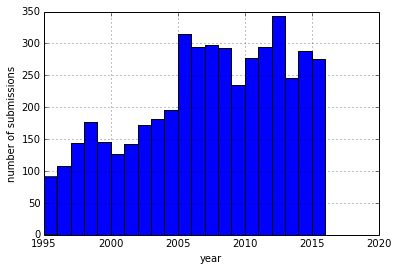

In [4]:
import matplotlib.pyplot as plt
#%matplotlib qt
%matplotlib inline

df['year'].hist(bins=xrange(1995, 2020))
plt.xlabel('year')
plt.ylabel('number of submissions')

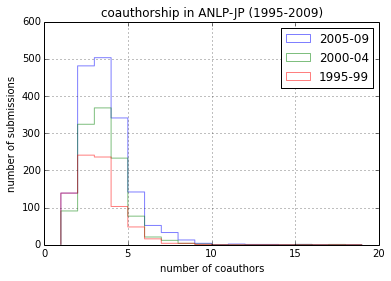

In [5]:
df[df['year'].between(2005, 2010)]['authors_num'].hist(bins=xrange(1,20), alpha=0.5, histtype='step', label='2005-09')
df[df['year'].between(2000, 2005)]['authors_num'].hist(bins=xrange(1,20), alpha=0.5, histtype='step', label='2000-04')
df[df['year'].between(1995, 2000)]['authors_num'].hist(bins=xrange(1,20), alpha=0.5, histtype='step', label='1995-99')
plt.legend(loc='upper right')
plt.xlabel('number of coauthors')
plt.ylabel('number of submissions')
plt.title('coauthorship in ANLP-JP (1995-2009)')

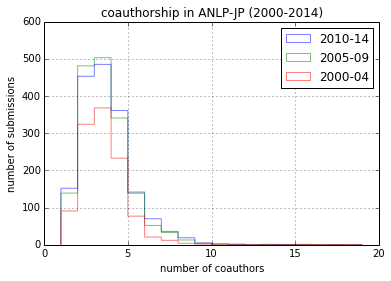

In [6]:
df[df['year'].between(2010, 2015)]['authors_num'].hist(bins=xrange(1,20), alpha=0.5, histtype='step', label='2010-14')
df[df['year'].between(2005, 2010)]['authors_num'].hist(bins=xrange(1,20), alpha=0.5, histtype='step', label='2005-09')
df[df['year'].between(2000, 2005)]['authors_num'].hist(bins=xrange(1,20), alpha=0.5, histtype='step', label='2000-04')
plt.legend(loc='upper right')
plt.xlabel('number of coauthors')
plt.ylabel('number of submissions')
plt.title('coauthorship in ANLP-JP (2000-2014)')

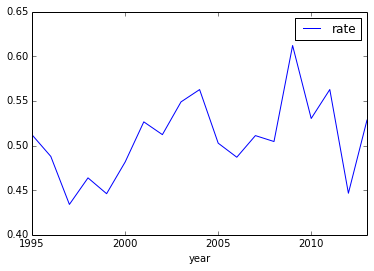

In [7]:
from collections import defaultdict
coauthors = defaultdict(set)

for (_, r) in df[['year', 'authors']].iterrows():
    for x in r[1]:
        coauthors[r[0]].add(x)
retention = {}
for k, v in coauthors.items():
    if k + 1 and k + 2 in coauthors:
        vv = coauthors[k + 1]
        vvv = coauthors[k + 2]
        retention[k] = 1.0 * len(v.intersection(vv.union(vvv))) / len(v)
dfy = pd.DataFrame(retention.items(), columns=['year', 'retention_rate'])
dfy.set_index('year')
dfy.plot(x='year', y='retention_rate')